In [159]:
import math
import numpy
import torch
import torch.nn as nn
import torchaudio
torchaudio.set_audio_backend("soundfile")
import matplotlib.pyplot as plt

In [160]:
class AudioSample:
    def __init__(self, filepath):
        loadedData = torchaudio.load(filepath)
        self.waveform = loadedData[0][0]
        self.sampleRate = loadedData[1]
        del loadedData
        self.pitchDeltas = torch.tensor([], dtype = int)
        self.pitchBorders = torch.tensor([], dtype = int)
        self.Pitch = torch.tensor([0], dtype = int)
        self.spectra = torch.tensor([[]], dtype = float)
        self.spectrum = torch.tensor([], dtype = float)
        self.excitation = torch.tensor([], dtype = float) #replace with periodic and aperiodic excitation once implemented
        
        self.MainOsc = torch.tensor([], dtype = float)
        
    def CalculatePitch(self, expectedPitch, searchRange = 0.2):
        batchSize = math.floor((1. + searchRange) * self.sampleRate / expectedPitch)
        lowerSearchLimit = math.floor((1. - searchRange) * self.sampleRate / expectedPitch)
        batchStart = 0
        while batchStart + batchSize <= self.waveform.size()[0] - batchSize:
            sample = torch.index_select(self.waveform, 0, torch.linspace(batchStart, batchStart + batchSize, batchSize, dtype = int))
            zeroTransitions = torch.tensor([], dtype = int)
            for i in range(lowerSearchLimit, batchSize):
                if (sample[i-1] < 0) and (sample[i] > 0):
                    zeroTransitions = torch.cat([zeroTransitions, torch.tensor([i])], 0)
            error = math.inf
            delta = math.floor(self.sampleRate / expectedPitch)
            for i in zeroTransitions:
                shiftedSample = torch.index_select(self.waveform, 0, torch.linspace(batchStart + i.item(), batchStart + batchSize + i.item(), batchSize, dtype = int))
                newError = torch.sum(torch.pow(sample - shiftedSample, 2))
                if error > newError:
                    delta = i.item()
                    error = newError
            self.pitchDeltas = torch.cat([self.pitchDeltas, torch.tensor([delta])])
            batchStart += delta
        nBatches = self.pitchDeltas.size()[0]
        self.pitchBorders = torch.zeros(nBatches + 1, dtype = int)
        for i in range(nBatches):
            self.pitchBorders[i+1] = self.pitchBorders[i] + self.pitchDeltas[i]
        self.Pitch = torch.mean(self.pitchDeltas.float()).int()
        del batchSize
        del lowerSearchLimit
        del batchStart
        del sample
        del zeroTransitions
        del error
        del delta
        del shiftedSample
        del newError
        del nBatches
    def CalculateSpectra(self, iterations = 10, filterWidth = 20):
        Window = torch.hann_window(self.Pitch * 3)

        
        """self.MainOsc = torch.empty(self.waveform.size()[0])
        for i in range(self.waveform.size()[0]):
            
            EnvSin = math.pow(math.sin(i * 0.5 * math.pi / self.Pitch - math.pi / 4), 2)
            EnvCos = math.pow(math.cos(i * 0.5 * math.pi / self.Pitch - math.pi / 4), 2)
            
            sineComp = int(math.floor(i / self.Pitch))
            cosComp = int(math.ceil(i / self.Pitch))
            cosComp = min(cosComp, signals.size()[0] - 1)
            
            self.MainOsc[i] = EnvSin * f0[sineComp].abs() * math.sin(2 * math.pi * i / self.Pitch + f0[sineComp].angle())
            self.MainOsc[i] += EnvCos * f0[cosComp].abs() * math.sin(2 * math.pi * i / self.Pitch + f0[cosComp].angle())
            self.MainOsc[i] += EnvSin * f1[sineComp].abs() * math.sin(4 * math.pi * i / self.Pitch + f1[sineComp].angle())
            self.MainOsc[i] += EnvCos * f1[cosComp].abs() * math.sin(4 * math.pi * i / self.Pitch + f1[cosComp].angle())"""
        
        #self.waveform -= self.MainOsc
        
        signals = torch.stft(self.waveform, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, return_complex = True)
        
        """signals[0] = 0.
        signals[1] = 0.
        signals[2] = 0.
        signals[3] = 0.
        signals[4] = 0.
        signals[5] = 0.
        signals[6] = 0.
        signals[7] = 0.
        signals[8] = 0.
        signals[9] = 0.
        signals[10] = 0."""
        
        signals = torch.transpose(signals, 0, 1)
        
        signals = torch.log(signals)
        
        workingSpectra = signals.abs()
        self.spectra = torch.full_like(workingSpectra, -float("inf"), dtype=torch.float)
        for i in range(iterations):
            workingSpectra = torch.max(workingSpectra, self.spectra)
            self.spectra = workingSpectra
            for i in range(filterWidth):
                self.spectra = torch.roll(workingSpectra, -i, dims = 1) + self.spectra + torch.roll(workingSpectra, i, dims = 1)
            self.spectra = self.spectra / (2 * filterWidth + 1)
        self.spectrum = torch.mean(self.spectra, 0)
        for i in range(self.spectra.size()[0]):
            self.spectra[i] = self.spectra[i] - self.spectrum
        del Window
        del signals
        del workingSpectra
    def CalculateExcitation(self):
        Window = torch.hann_window(self.Pitch * 3)
        signals = torch.stft(self.waveform, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, return_complex = True)
        signals = torch.transpose(signals, 0, 1)
        excitations = torch.empty_like(signals)
        for i in range(excitations.size()[0]):
            excitations[i] = signals[i] / (torch.exp(self.spectrum) + torch.exp(self.spectra[i]))
        excitations = torch.transpose(excitations, 0, 1)
        self.excitation = torch.istft(excitations, self.Pitch * 3, hop_length = self.Pitch, win_length = self.Pitch * 3, window = Window, onesided = True)
        del Window
        del signals
        del excitations

In [171]:
class Synthesizer:
    def __init__(self, Excitation, Spectrum, Spectra, SampleRate):
        self.excitation = Excitation
        self.spectrum = Spectrum
        self.spectra = Spectra
        self.sampleRate = SampleRate
        self.returnSignal = torch.tensor([], dtype = float)
    def Synthesize(self, pitch, steadiness):
        Window = torch.hann_window(pitch * 3)
        self.returnSignal = torch.stft(self.excitation, pitch * 3, hop_length = pitch, win_length = pitch * 3, window = Window, return_complex = True)
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        for i in range(self.spectra.size()[0]):
            self.returnSignal[i] = self.returnSignal[i] * torch.exp(specCrfAi.processData(trainSpectra[0], trainSpectra[-1], float(i) / 19.).detach())
            #self.returnSignal[i] = self.returnSignal[i] * (torch.exp(self.spectrum) + math.pow(1 - steadiness, 2) * torch.roll(torch.exp(self.spectra), 0, dims=0)[i])
        self.returnSignal = torch.transpose(self.returnSignal, 0, 1)
        self.returnSignal = torch.istft(self.returnSignal, pitch * 3, hop_length = pitch, win_length = pitch * 3, window = Window, onesided=True, )
        del Window
    def save(self, filepath):
        torchaudio.save(filepath, torch.unsqueeze(self.returnSignal, 0), self.sampleRate, format="wav", encoding="PCM_S", bits_per_sample=32)

In [162]:
class RelLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(RelLoss, self).__init__()
 
    def forward(self, inputs, targets):    
        
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        differences = torch.abs(inputs - targets)
        sums = torch.abs(inputs + targets)
        out = (differences / sums).sum() / inputs.size()[0]
        
        return out

In [163]:
class SpecCrfAi(nn.Module):
    def __init__(self, inputsize, learningRate=1e-5):
        super(SpecCrfAi, self).__init__()
        
        self.layer1 = torch.nn.Conv2d(1, 10, (51, 3), padding = (25, 0), bias = False)
        self.ReLu1 = nn.ReLU()
        self.layer2 = torch.nn.Conv2d(10, 10, (51, 1), padding = (25, 0), bias = False)
        self.ReLu2 = nn.ReLU()
        self.layer3 = torch.nn.Conv2d(10, 10, (51, 1), padding = (25, 0), bias = False)
        self.ReLu3 = nn.ReLU()
        self.layer4 = torch.nn.Conv2d(10, 1, (51, 1), padding = (25, 0), bias = False)
        
        self.learningRate = learningRate
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.learningRate, weight_decay=0.)
        #self.criterion = nn.L1Loss()
        self.criterion = RelLoss()
        
    def forward(self, spectrum1, spectrum2, factor):
        fac = torch.full((spectrum1.size()[0], 1), factor)
        x = torch.cat((spectrum1.unsqueeze(1), fac, spectrum2.unsqueeze(1)), dim = 1)
        x = x.float().unsqueeze(0).unsqueeze(0)
        x = self.layer1(x)
        x = self.ReLu1(x)
        x = self.layer2(x)
        x = self.ReLu2(x)
        x = self.layer3(x)
        x = self.ReLu3(x)
        x = self.layer4(x)
        return x
    
    def processData(self, spectrum1, spectrum2, factor):
        #spectrum1 = torch.log(spectrum1)
        #spectrum2 = torch.log(spectrum2)
        output = torch.squeeze(self(spectrum1, spectrum2, factor))
        #output = torch.exp(output)
        return output
    
    def train(self, indata, epochs=1):
        for epoch in range(epochs):
            for data in self.dataLoader(indata):
                spectrum1 = data[0]
                spectrum2 = data[-1]
                #spectrum1 = torch.log(spectrum1)
                #spectrum2 = torch.log(spectrum2)
                indexList = numpy.arange(0, data.size()[0], 1)
                numpy.random.shuffle(indexList)
                for i in indexList:
                    factor = i / float(data.size()[0])
                    spectrumTarget = data[i]
                    #spectrumTarget = torch.log(spectrumTarget)
                    output = torch.squeeze(self(spectrum1, spectrum2, factor))
                    loss = self.criterion(output, spectrumTarget)
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            print('epoch [{}/{}], loss:{:.4f}'
                  .format(epoch + 1, epochs, loss.data))
            
    def dataLoader(self, data):
        return torch.utils.data.DataLoader(dataset=data, shuffle=True)

In [164]:

audioSample1 = AudioSample("Samples/a_a.wav")
audioSample1.CalculatePitch(95.)
audioSample1.CalculateSpectra()
audioSample1.CalculateExcitation()

audioSample2 = AudioSample("Samples/a_i.wav")
audioSample2.CalculatePitch(95.)
audioSample2.CalculateSpectra(iterations = 50)
audioSample2.CalculateExcitation()

audioSample3 = AudioSample("Samples/a_u.wav")
audioSample3.CalculatePitch(95.)
audioSample3.CalculateSpectra()
audioSample3.CalculateExcitation()

audioSample4 = AudioSample("Samples/e_a.wav")
audioSample4.CalculatePitch(95.)
audioSample4.CalculateSpectra()
audioSample4.CalculateExcitation()

audioSample5 = AudioSample("Samples/i_a.wav")
audioSample5.CalculatePitch(95.)
audioSample5.CalculateSpectra()
audioSample5.CalculateExcitation()

audioSample6 = AudioSample("Samples/u_e.wav")
audioSample6.CalculatePitch(95.)
audioSample6.CalculateSpectra()
audioSample6.CalculateExcitation()


In [165]:
trainSpectra = torch.empty_like(audioSample2.spectra)
for i in range(audioSample2.spectra.size()[0]):
    trainSpectra[i] = audioSample2.spectrum + audioSample2.spectra[i]
specCrfAi = SpecCrfAi(trainSpectra.size()[1])
specCrfAi.train(trainSpectra, epochs = 1000)

epoch [1/1000], loss:0.9756
epoch [2/1000], loss:0.9425
epoch [3/1000], loss:0.9060
epoch [4/1000], loss:0.8677
epoch [5/1000], loss:0.8048
epoch [6/1000], loss:0.7031
epoch [7/1000], loss:0.5488
epoch [8/1000], loss:0.3685
epoch [9/1000], loss:0.1924
epoch [10/1000], loss:0.0342
epoch [11/1000], loss:0.0091
epoch [12/1000], loss:0.0091
epoch [13/1000], loss:0.0091
epoch [14/1000], loss:0.0079
epoch [15/1000], loss:0.0083
epoch [16/1000], loss:0.0075
epoch [17/1000], loss:0.0075
epoch [18/1000], loss:0.0076
epoch [19/1000], loss:0.0070
epoch [20/1000], loss:0.0069
epoch [21/1000], loss:0.0071
epoch [22/1000], loss:0.0072
epoch [23/1000], loss:0.0065
epoch [24/1000], loss:0.0074
epoch [25/1000], loss:0.0066
epoch [26/1000], loss:0.0068
epoch [27/1000], loss:0.0067
epoch [28/1000], loss:0.0065
epoch [29/1000], loss:0.0064
epoch [30/1000], loss:0.0067
epoch [31/1000], loss:0.0065
epoch [32/1000], loss:0.0068
epoch [33/1000], loss:0.0062
epoch [34/1000], loss:0.0062
epoch [35/1000], loss:0

epoch [278/1000], loss:0.0028
epoch [279/1000], loss:0.0026
epoch [280/1000], loss:0.0025
epoch [281/1000], loss:0.0025
epoch [282/1000], loss:0.0029
epoch [283/1000], loss:0.0029
epoch [284/1000], loss:0.0027
epoch [285/1000], loss:0.0023
epoch [286/1000], loss:0.0025
epoch [287/1000], loss:0.0025
epoch [288/1000], loss:0.0025
epoch [289/1000], loss:0.0026
epoch [290/1000], loss:0.0026
epoch [291/1000], loss:0.0025
epoch [292/1000], loss:0.0024
epoch [293/1000], loss:0.0026
epoch [294/1000], loss:0.0025
epoch [295/1000], loss:0.0026
epoch [296/1000], loss:0.0026
epoch [297/1000], loss:0.0024
epoch [298/1000], loss:0.0024
epoch [299/1000], loss:0.0024
epoch [300/1000], loss:0.0028
epoch [301/1000], loss:0.0025
epoch [302/1000], loss:0.0024
epoch [303/1000], loss:0.0024
epoch [304/1000], loss:0.0024
epoch [305/1000], loss:0.0023
epoch [306/1000], loss:0.0025
epoch [307/1000], loss:0.0024
epoch [308/1000], loss:0.0024
epoch [309/1000], loss:0.0024
epoch [310/1000], loss:0.0023
epoch [311

epoch [552/1000], loss:0.0016
epoch [553/1000], loss:0.0018
epoch [554/1000], loss:0.0017
epoch [555/1000], loss:0.0016
epoch [556/1000], loss:0.0018
epoch [557/1000], loss:0.0017
epoch [558/1000], loss:0.0020
epoch [559/1000], loss:0.0019
epoch [560/1000], loss:0.0019
epoch [561/1000], loss:0.0017
epoch [562/1000], loss:0.0019
epoch [563/1000], loss:0.0018
epoch [564/1000], loss:0.0019
epoch [565/1000], loss:0.0017
epoch [566/1000], loss:0.0020
epoch [567/1000], loss:0.0017
epoch [568/1000], loss:0.0017
epoch [569/1000], loss:0.0017
epoch [570/1000], loss:0.0017
epoch [571/1000], loss:0.0017
epoch [572/1000], loss:0.0017
epoch [573/1000], loss:0.0016
epoch [574/1000], loss:0.0020
epoch [575/1000], loss:0.0017
epoch [576/1000], loss:0.0018
epoch [577/1000], loss:0.0018
epoch [578/1000], loss:0.0018
epoch [579/1000], loss:0.0017
epoch [580/1000], loss:0.0017
epoch [581/1000], loss:0.0017
epoch [582/1000], loss:0.0020
epoch [583/1000], loss:0.0017
epoch [584/1000], loss:0.0018
epoch [585

epoch [826/1000], loss:0.0005
epoch [827/1000], loss:0.0005
epoch [828/1000], loss:0.0004
epoch [829/1000], loss:0.0008
epoch [830/1000], loss:0.0005
epoch [831/1000], loss:0.0005
epoch [832/1000], loss:0.0005
epoch [833/1000], loss:0.0007
epoch [834/1000], loss:0.0007
epoch [835/1000], loss:0.0005
epoch [836/1000], loss:0.0007
epoch [837/1000], loss:0.0007
epoch [838/1000], loss:0.0007
epoch [839/1000], loss:0.0010
epoch [840/1000], loss:0.0008
epoch [841/1000], loss:0.0006
epoch [842/1000], loss:0.0005
epoch [843/1000], loss:0.0005
epoch [844/1000], loss:0.0007
epoch [845/1000], loss:0.0005
epoch [846/1000], loss:0.0006
epoch [847/1000], loss:0.0005
epoch [848/1000], loss:0.0007
epoch [849/1000], loss:0.0005
epoch [850/1000], loss:0.0005
epoch [851/1000], loss:0.0006
epoch [852/1000], loss:0.0004
epoch [853/1000], loss:0.0005
epoch [854/1000], loss:0.0005
epoch [855/1000], loss:0.0004
epoch [856/1000], loss:0.0006
epoch [857/1000], loss:0.0005
epoch [858/1000], loss:0.0005
epoch [859

In [172]:
synthesizer = Synthesizer(audioSample2.excitation, audioSample2.spectrum, audioSample2.spectra, audioSample2.sampleRate)
synthesizer.Synthesize(audioSample2.Pitch, 1.)
synthesizer.save("Output_high_Steadiness.wav")

In [167]:
output = specCrfAi.processData(trainSpectra[0], trainSpectra[-1], 0.5).detach()

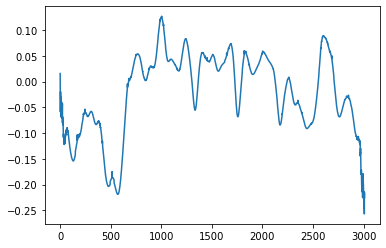

In [168]:
plt.plot((trainSpectra[9] - output) / trainSpectra[9])

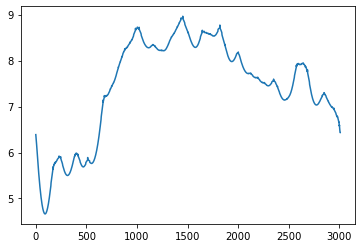

In [169]:
plt.plot(trainSpectra[9])

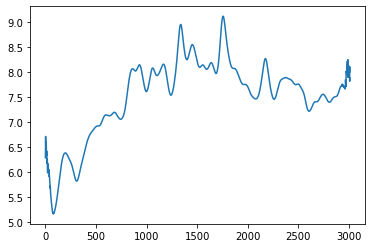

In [170]:
plt.plot(output)